In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.optimizers import Adam
import os

In [16]:
category = 9

## Load CIFAR-10 data and Normalized

In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


## Get truck image

In [18]:
x_train = x_train[y_train.flatten() == category]
x_test = x_test[y_test.flatten() == category]

In [19]:
print(len(x_test))

1000


## Helper Function

In [20]:

# Function to remove the center of CIFAR-10 images
def get_mask(imgs, mask_size=8):
    mask = imgs.copy()
    center_x, center_y = imgs.shape[1] // 2, imgs.shape[2] // 2
    mask = mask[:, center_x-mask_size:center_x+mask_size, center_y-mask_size:center_y+mask_size, :]
    return mask
# Function to remove the center of CIFAR-10 images
def remove_center(imgs, mask_size=8):
    masked_imgs = imgs.copy()
    center_x, center_y = imgs.shape[1] // 2, imgs.shape[2] // 2
    masked_imgs[:, center_x-mask_size:center_x+mask_size, center_y-mask_size:center_y+mask_size, :] = 0
    return masked_imgs
# Apply masking to training and test images
x_train_removed = remove_center(x_train)
x_test_removed = remove_center(x_test)
x_train_mask = get_mask(x_train)
x_test_mask = get_mask(x_test)

print(x_train[0].shape)
print(x_train_removed[0].shape)
print(x_train_mask[0].shape)

(32, 32, 3)
(32, 32, 3)
(16, 16, 3)


In [21]:
def insert_generated_center(original_images, generated_centers, center_size=16):

    # Calculate start and end indices for center insertion
    start = (original_images.shape[1] - center_size) // 2
    end = start + center_size

    # Make a copy of the original images to avoid modifying the original array
    images_with_centers = np.copy(original_images)

    # Replace the center of each image with the generated patch
    images_with_centers[:, start:end, start:end, :] = generated_centers

    return images_with_centers

In [22]:
def mse(imageA, imageB):
    # Ensure the images are floating point values
    imageA = imageA.astype('float32')
    imageB = imageB.astype('float32')
    # Compute the mean squared error between the two images
    err = np.mean((imageA - imageB) ** 2)
    return err

## Visualize Graph Before make Prediction

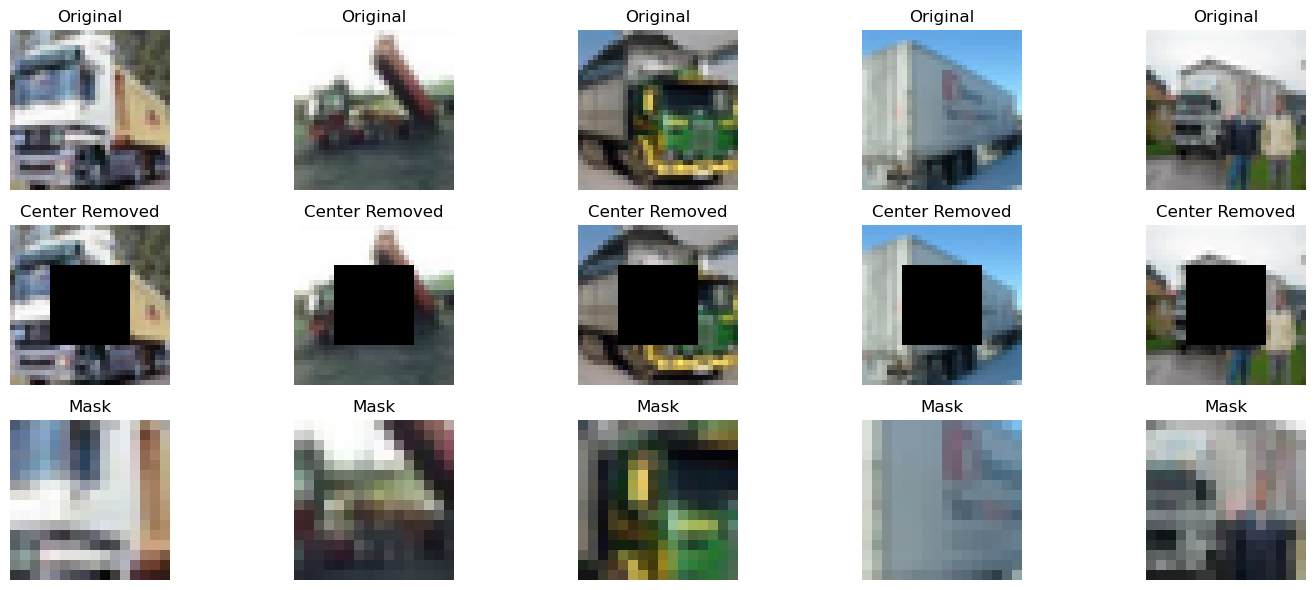

In [23]:
fig, axs = plt.subplots(3, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(x_train[i])
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(x_train_removed[i])
    axs[1, i].set_title('Center Removed')
    axs[1, i].axis('off')

    axs[2, i].imshow(x_train_mask[i])
    axs[2, i].set_title('Mask')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

## Build Model

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input

def build_encoder_decoder(input_shape=(32, 32, 3), output_shape=(16, 16, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Ensuring we have a suitable feature map size

    # Fully Connected layer simulation (reshape -> dense -> reshape)
    x = Flatten()(encoded)
    x = Dense(4096, activation='relu')(x)  # Experiment with the size
    x = Reshape((4, 4, 256))(x)  # Adjust size based on Dense layer output

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # Adjust to target output size
    decoded = Conv2D(output_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=input_img, outputs=decoded)
    return model

encoder_decoder = build_encoder_decoder()
encoder_decoder.compile(optimizer='adam', loss='mse')

encoder_decoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 128)       512 

## Train Model

In [30]:
# Fit the model and save the history
history = encoder_decoder.fit(x_train_removed, x_train_mask,
                              epochs=100,
                              batch_size=128,
                              shuffle=True,
                              validation_data=(x_test_removed, x_test_mask))


Epoch 1/100
40/40 [==============================] - 3s 80ms/step - loss: 0.0074 - val_loss: 0.0366
Epoch 2/100
40/40 [==============================] - 3s 86ms/step - loss: 0.0070 - val_loss: 0.0362
Epoch 3/100
40/40 [==============================] - 4s 89ms/step - loss: 0.0068 - val_loss: 0.0366
Epoch 4/100
40/40 [==============================] - 4s 94ms/step - loss: 0.0066 - val_loss: 0.0363
Epoch 5/100
40/40 [==============================] - 4s 92ms/step - loss: 0.0066 - val_loss: 0.0365
Epoch 6/100
40/40 [==============================] - 4s 90ms/step - loss: 0.0063 - val_loss: 0.0365
Epoch 7/100
40/40 [==============================] - 3s 88ms/step - loss: 0.0059 - val_loss: 0.0376
Epoch 8/100
40/40 [==============================] - 4s 92ms/step - loss: 0.0063 - val_loss: 0.0381
Epoch 9/100
40/40 [==============================] - 4s 91ms/step - loss: 0.0063 - val_loss: 0.0374
Epoch 10/100
40/40 [==============================] - 4s 92ms/step - loss: 0.0058 - val_loss: 0.0372

Epoch 82/100
40/40 [==============================] - 6s 138ms/step - loss: 0.0023 - val_loss: 0.0359
Epoch 83/100
40/40 [==============================] - 5s 116ms/step - loss: 0.0024 - val_loss: 0.0358
Epoch 84/100
40/40 [==============================] - 5s 130ms/step - loss: 0.0024 - val_loss: 0.0359
Epoch 85/100
40/40 [==============================] - 5s 123ms/step - loss: 0.0024 - val_loss: 0.0363
Epoch 86/100
40/40 [==============================] - 5s 122ms/step - loss: 0.0025 - val_loss: 0.0365
Epoch 87/100
40/40 [==============================] - 5s 121ms/step - loss: 0.0027 - val_loss: 0.0361
Epoch 88/100
40/40 [==============================] - 5s 113ms/step - loss: 0.0024 - val_loss: 0.0358
Epoch 89/100
40/40 [==============================] - 7s 166ms/step - loss: 0.0022 - val_loss: 0.0358
Epoch 90/100
40/40 [==============================] - 5s 122ms/step - loss: 0.0022 - val_loss: 0.0355
Epoch 91/100
40/40 [==============================] - 5s 123ms/step - loss: 0.0021

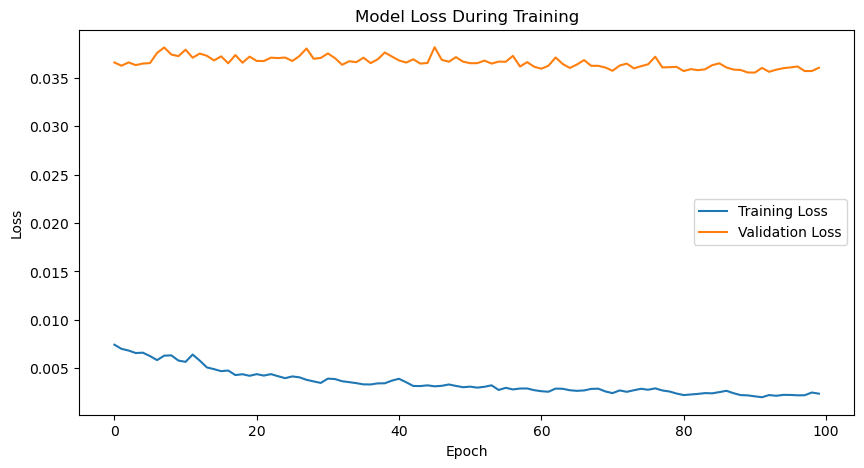

In [31]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Make Prediction

In [54]:
generated_images = encoder_decoder.predict(x_test_removed[:])

image_with_center = insert_generated_center(x_test_removed[:], generated_images)

32/32 [==============================] - 0s 11ms/step


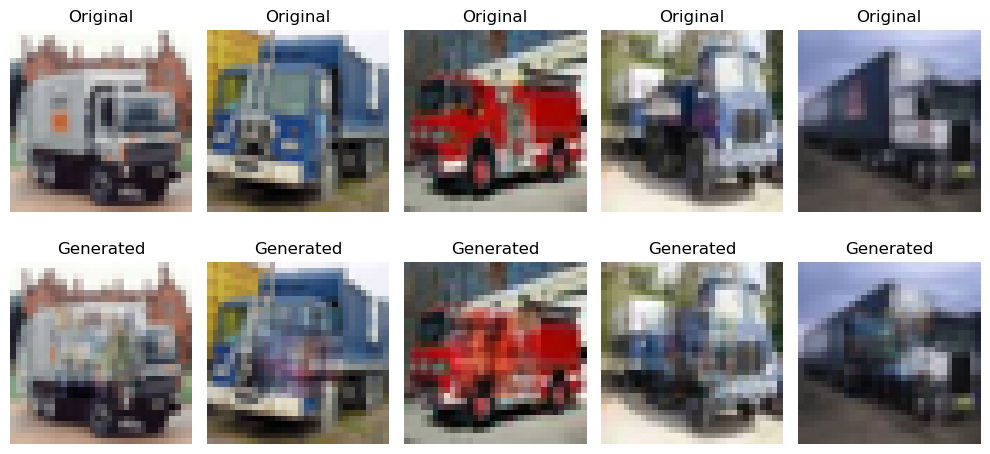

Average MSE: 0.009005878120660782


In [55]:
# Select a few images to display
num_images = 5


fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
#Average MSE for all Trucks
mse_values = []
for i in range(len(x_test)):
    mse_values.append(mse(x_test[i], image_with_center[i]))
#print(len(mse_values))
average_mse = np.mean(mse_values)
print(f'Average MSE: {average_mse}')

## Upper left mask

In [45]:
def remove_and_return_upper_left_corner(imgs, mask_size):
    masked_imgs = imgs.copy()
    
    # The starting indices for the upper left corner are both 0
    start_row = 0
    start_col = 0
    
    # Extract the upper left corner
    upper_left_corners = imgs[:, start_row:start_row+mask_size, start_col:start_col+mask_size, :].copy()
    
    # Set the upper left corner to zero in the masked images
    masked_imgs[:, start_row:start_row+mask_size, start_col:start_col+mask_size, :] = 0
    
    return masked_imgs, upper_left_corners

# Function usage
mask_size = 16  # for example, to remove a 16x16 patch from the upper left corner
x_train_masked, x_train_corners = remove_and_return_upper_left_corner(x_train, mask_size)
x_test_masked, x_test_corners = remove_and_return_upper_left_corner(x_test, mask_size)

# Shapes of the original, masked, and corner images
print(x_train[0].shape)
print(x_train_masked[0].shape)
print(x_train_corners[0].shape)

(32, 32, 3)
(32, 32, 3)
(16, 16, 3)


In [46]:
def insert_generated_upper_left_corner(original_images, generated_corners, corner_size=16):
    # The start indices for the upper left corner are both 0
    start_row = 0
    start_col = 0
    
    # Make a copy of the original images to avoid modifying the original array
    images_with_upper_left_corners = np.copy(original_images)

    # Replace the upper left corner of each image with the generated patch
    # Ensure that the generated_corners array matches the dimensions where it's being inserted
    images_with_upper_left_corners[:, start_row:start_row+corner_size, start_col:start_col+corner_size, :] = generated_corners

    return images_with_upper_left_corners

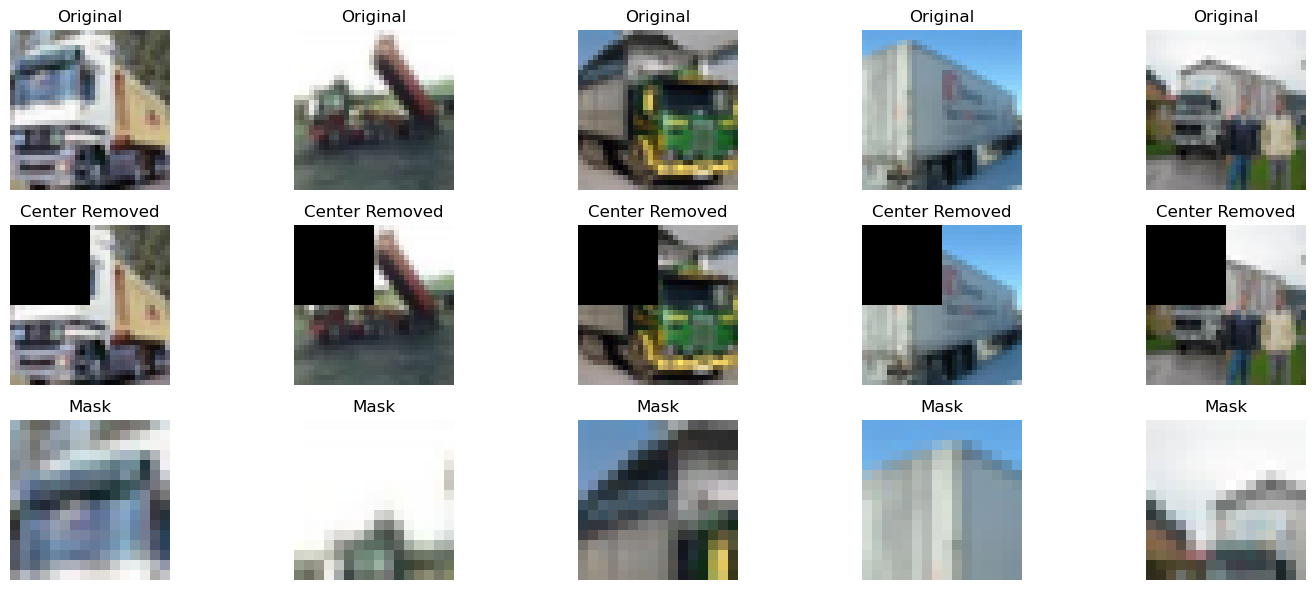

In [47]:
fig, axs = plt.subplots(3, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(x_train[i])
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(x_train_masked[i])
    axs[1, i].set_title('Center Removed')
    axs[1, i].axis('off')

    axs[2, i].imshow(x_train_corners[i])
    axs[2, i].set_title('Mask')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

encoder_decoder_2 = build_encoder_decoder()
# Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitors the validation loss
#     patience=5,         # Number of epochs with no improvement after which training will be stopped
#     verbose=1,          # To log when training is stopped
#     restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss
# )

# Compile your model
encoder_decoder_2.compile(optimizer='adam', loss='mse')

# Fit the model with the early stopping callback
history = encoder_decoder_2.fit(
    x_train_masked, x_train_corners,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_masked, x_test_corners),
#     callbacks=[early_stopping]  # Add early stopping callback here
)

Epoch 1/30
40/40 [==============================] - 5s 78ms/step - loss: 0.0623 - val_loss: 0.0841
Epoch 2/30
40/40 [==============================] - 2s 61ms/step - loss: 0.0417 - val_loss: 0.1096
Epoch 3/30
40/40 [==============================] - 2s 60ms/step - loss: 0.0392 - val_loss: 0.1492
Epoch 4/30
40/40 [==============================] - 2s 58ms/step - loss: 0.0384 - val_loss: 0.1681
Epoch 5/30
40/40 [==============================] - 2s 56ms/step - loss: 0.0369 - val_loss: 0.1821
Epoch 6/30
40/40 [==============================] - 2s 56ms/step - loss: 0.0350 - val_loss: 0.2020
Epoch 7/30
40/40 [==============================] - 2s 58ms/step - loss: 0.0343 - val_loss: 0.1691
Epoch 8/30
40/40 [==============================] - 2s 56ms/step - loss: 0.0321 - val_loss: 0.1530
Epoch 9/30
40/40 [==============================] - 2s 57ms/step - loss: 0.0301 - val_loss: 0.1072
Epoch 10/30
40/40 [==============================] - 2s 55ms/step - loss: 0.0284 - val_loss: 0.0943
Epoch 11/

32/32 [==============================] - 0s 10ms/step


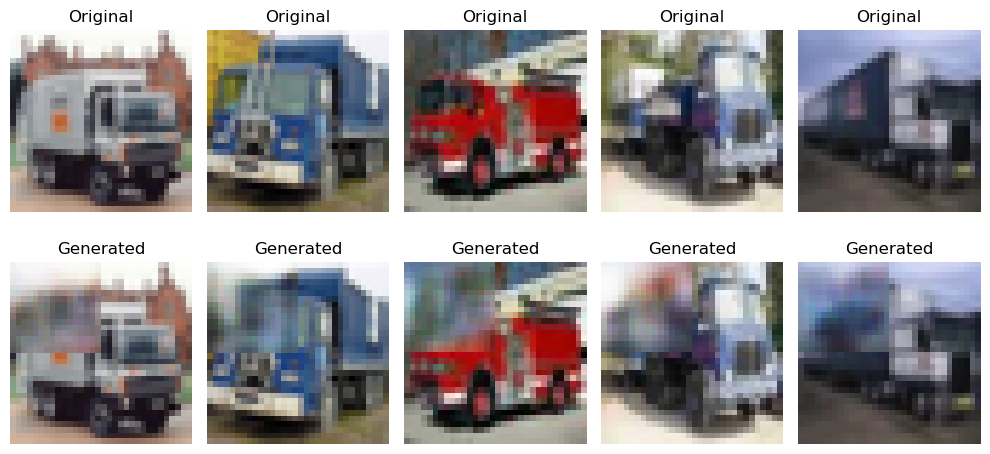

Average MSE: 0.011057212948799133


In [52]:
generated_images = encoder_decoder_2.predict(x_test_masked[:])

image_with_center = insert_generated_upper_left_corner(x_test_masked[:], generated_images)

num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')